In [0]:
# Wrote out own multilayer perceptron class and methods.

import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

# Transform the images to tensors, and normalize the pixel values to lie between 1 and -1
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
     # values normed btw 0 and 1 originally 
     transforms.Lambda(lambda x : x.resize_(3*32*32,1)), # immediately resize the tensors to be 3072*1 column vectors
     transforms.Lambda(lambda x : torch.cat((x, torch.Tensor(np.array([1])[:,None])))) # added a bias term to end of column vector
     ])

# Choose to run on gpu if available, else choose cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Code to create train and validation set
# Copied from https://github.com/pytorch/vision/issues/168
class ChunkSampler(torch.utils.data.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

# The validation set is the last 10000 images in the train set.
NUM_TRAIN = 40000
NUM_VAL = 10000

trainset = dset.CIFAR10(root='./cifar-10-batches-py', train=True, download=True, transform=transform)

loaderSize = 100 

# Sent in to load batches for SDG
batchloader = torch.utils.data.DataLoader(trainset, batch_size=1500, sampler=ChunkSampler(NUM_TRAIN, 0), num_workers=2)

# Loads training data for outputting train acc
trainloader = torch.utils.data.DataLoader(trainset, batch_size=loaderSize, sampler=ChunkSampler(NUM_TRAIN, 0), num_workers=4)

# We use a different dataloader for cost function so that we don't calculate cost on same examples we calculate gradient with
costloader = torch.utils.data.DataLoader(trainset, batch_size=loaderSize, sampler=ChunkSampler(NUM_TRAIN,0), num_workers=2)

valset = dset.CIFAR10(root='./cifar-10-batches-py', train=True, download=True, transform=transform)
# Here, we set size of validation set and define a loader for it
valloader = torch.utils.data.DataLoader(valset, batch_size=loaderSize, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN), num_workers=2)

testset = dset.CIFAR10(root='./cifar-10-batches-py', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=loaderSize, sampler=ChunkSampler(len(testset), 0), num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Device: cuda:0


Extracting ./cifar-10-batches-py/cifar-10-python.tar.gz to ./cifar-10-batches-py
Files already downloaded and verified
Files already downloaded and verified


# SimpleMLP class 

-----------------------
Epoch 1
Learning rate: 0.5
Cost =  3.6587138370764034
Train acc =  0.2189
Val acc =  0.2213
Test acc = 0.222
-----------------------
Epoch 2
Learning rate: 0.3511112189344993
Cost =  4.81597859769231
Val acc =  0.1726
Test acc = 0.1755
-----------------------
Epoch 3
Learning rate: 0.2855210712786319
Cost =  3.54097381229669
Train acc =  0.1756
Val acc =  0.1748
Test acc = 0.1759
-----------------------
Epoch 4
Learning rate: 0.2465581761233398
Cost =  2.7445124492600828
Val acc =  0.2015
Test acc = 0.2084
-----------------------
Epoch 5
Learning rate: 0.2200367907561858
Cost =  2.224498065175261
Train acc =  0.29505
Val acc =  0.2919
Test acc = 0.29
-----------------------
Epoch 6
Learning rate: 0.200499302736249
Cost =  1.821647715238973
Val acc =  0.3043
Test acc = 0.3102
-----------------------
Epoch 7
Learning rate: 0.18534036071748025
Cost =  1.8438527372175821
Train acc =  0.361575
Val acc =  0.3525
Test acc = 0.3586
-----------------------
Epoch 8
Learni

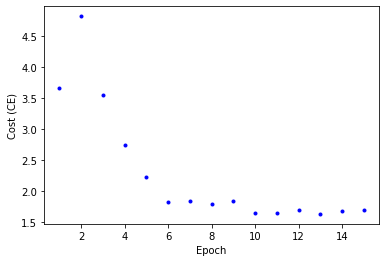

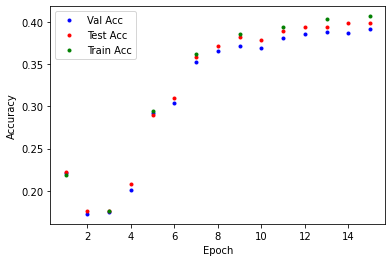

************************
Train acc: 0.406675
Val acc: 0.3916
Test acc: 0.3984
Time elapsed: 413.3180603981018
*************************



In [0]:
class SimpleMLP:

  '''Fit and predict a dataset loaded by batchLoader using a multilayer perceptron.
  Assumes a single hidden layer with M hidden units,
  with ReLu activation on the hidden layer and softmax activation on the output.
  Takes in dataloaders set with appropriate batch sizes to load the train, validation
  and test set. For the purposes of this assignment, the fit method contains the code
  to output plots of the train, validation and test accuracy over the epochs.'''

  def __init__(self, D, classes, M, batchLoader, costLoader, trainLoader, valLoader, testLoader, lr=0.1, maxEpochs=100, verbose=False):
    self.lr = lr # initial learning rate for stochastic gradient descent (SGD)
    self.maxEpochs = maxEpochs # Max number of SGD iterations

    self.batchLoader = batchLoader
    self.costLoader = costLoader
    self.trainLoader = trainLoader
    self.valLoader = valLoader
    self.testLoader = testLoader
    self.verbose = verbose

    self.D = D # Input dimension
    self.M = M # Number of hidden units
    self.C = len(classes) # Number of output classes

    # Approximate Xavier initialization of weights
    # Make all parameters doubles to reduce softmax saturation
    self.W = torch.randn((self.M, self.D), dtype=torch.float64, device=device)*1/np.sqrt(self.D)
    self.V = torch.randn((self.C, self.M + 1), dtype=torch.float64, device=device)*1/np.sqrt(self.D)
    # Initialize gradients 
    self.dW = torch.zeros_like(self.W, device=device)
    self.dV = torch.zeros_like(self.V, device=device) 

  def fit(self):
    # Initialize variables
    start = time.time() # For wall time calculation
    B = self.batchLoader.batch_size # batch size
    origlr = self.lr 
    batchIter = iter(self.batchLoader)
    costIter = iter(self.costLoader)

    # Initialize tensors to store plot vars
    epochs = torch.arange(1,self.maxEpochs+1)
    costs = torch.zeros_like(epochs, dtype=torch.double)
    trainAccs = torch.zeros((self.maxEpochs // 2) + 1, dtype=torch.double)
    trPlotEpochs = torch.zeros_like(trainAccs)
    valAccs = torch.zeros_like(epochs, dtype=torch.double)
    testAccs = torch.zeros_like(epochs, dtype=torch.double)

    # For keeping track of validation accuracy for stop condition
    oldValAcc = 0.0
    newValAcc = 0.0
    stop = False

    # Iterate until max number of epochs, or until stop condition is true
    # Stop condition is that validation accuracy has not changed by more than
    # 0.01 for three epochs.
    epoch = 1
    while (epoch <= self.maxEpochs) and stop != True:
      if self.verbose: print('-----------------------')
      if self.verbose: print("Epoch", epoch)
      
      # Schedule a smaller learning rate over time
      self.lr = origlr*epoch**-0.51
      if self.verbose: print("Learning rate:", self.lr)
 
      # Get minibatch, size set by batch_size of DataLoader
      images, labels = batchIter.next()
      images, labels = images.to(device), labels.to(device)

      # calculate gradient for each instance separately and add contributions from each instance
      for image, label in zip(images, labels):
        image = image.type(torch.float64)
        # cost += self.cost(image, label)
        dW_temp, dV_temp = self.gradient(image, label)
        self.dV += dV_temp
        self.dW += dW_temp
        # end for
      self.dW = self.dW / B
      self.dV = self.dV / B
      # Update weights
      self.W = self.W - self.lr*self.dW
      self.V = self.V - self.lr*self.dV

      # Calculate cost here, using a sample of 100 training instances
      cost = 0.0
      ims, labs = costIter.next()
      ims, labs = ims.to(device), labs.to(device)
      for im, lab in zip(ims, labs):
       im = im.type(torch.float64)
       cost += self.cost(im, lab) # gives the average cost of a single image
      cost = cost/len(ims) # take the average over all images
      if self.verbose: print('Cost = ', cost)

      # Get val accs for epoch
      vPreds, vTruths = self.predict(self.valLoader)
      tPreds, tTruths = self.predict(self.testLoader)
      # Preppring plot vars
      epochs[epoch-1] = epoch
      costs[epoch-1] = cost
      # Calculate training accuracy on entire 40000 training examples every other iteration
      if (epoch-1) % 2 == 0:
        trPreds, trTruths = self.predict(self.trainLoader)
        trainAccs[(epoch-1)//2] = accuracy_score(trTruths.cpu(), trPreds.cpu())
        if self.verbose: print('Train acc = ', trainAccs[(epoch-1)//2].item())
        trPlotEpochs[(epoch-1)//2] = epoch
      valAccs[epoch-1] = accuracy_score(vTruths.cpu(), vPreds.cpu()).item()
      if self.verbose: print('Val acc = ', valAccs[epoch-1].item())
      testAccs[epoch-1] = accuracy_score(tTruths.cpu(), tPreds.cpu()).item()
      if self.verbose: print('Test acc =', testAccs[epoch-1].item())

      # Check if valacc has plateaued every three iterations
      if epoch % 3 == 0:
        newValAcc = valAccs[epoch-1].item()
        if abs(newValAcc - oldValAcc) < 0.01:
          stop = True
          # Cut unfilled values of plot variables
          costs = costs[:epoch]
          trainAccs = trainAccs[:(((epoch-1)//2) + 1)]
          trPlotEpochs = trPlotEpochs[:(((epoch-1)//2) + 1)]
          valAccs = valAccs[:epoch]
          testAccs = testAccs[:epoch]
          epochs = epochs[:epoch]
        else:
          oldValAcc = newValAcc
      
      epoch += 1
      # End while
    # Do plots  
    plt.plot(epochs, costs, 'b.') 
    plt.xlabel('Epoch')
    plt.ylabel('Cost (CE)')
    plt.savefig(datetime.now().strftime("%m-%d--%H-%M") + "_B_" + str(B) + "_M_" + str(self.M) + "_lr_" + str(origlr) + "_cost_" + ".png")
    plt.show()

    plt.plot(epochs, valAccs, 'b.', label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epochs, testAccs, 'r.', label='Test Acc')
    plt.plot(trPlotEpochs, trainAccs, 'g.', label='Train Acc') 
    plt.legend()
    plt.savefig(datetime.now().strftime("%m-%d--%H-%M") + "_B_" + str(B) + "_M_" + str(self.M) + "_lr_" + str(origlr) + "_accs_" + ".png")
    plt.show()

    # Print outputs
    print("************************")
    print("Train acc:", trainAccs[-1].item())
    print("Val acc:", valAccs[-1].item())
    print("Test acc:", testAccs[-1].item())
    print("Time elapsed:", time.time()-start)
    print("*************************")
    
  def predict(self, fullSetLoader):
    # Tensors to store predictions and labels in
    predictions = torch.zeros(fullSetLoader.sampler.num_samples)
    labels = torch.zeros(fullSetLoader.sampler.num_samples)
    i = 0
    # Loop over all batches
    for ims, labs in fullSetLoader:
      # Loop over all instances in batch
      for x, y in zip(ims, labs):
        x = x.to(device)
        x = x.type(torch.float64)
        # x is image vector, D by 1
        # W is M by D
        # V is C by M + 1 (to account for bias in hidden layer)
        z = self.relu(torch.matmul(self.W, x)) # M by 1
        # Append bias term to z 
        bias = torch.zeros(([1,1]), dtype=torch.double, device=device)
        bias[0][0] = 1.0
        z = torch.cat((z,bias)) #  3073 X 1
        u = torch.matmul(self.V, z) # C by 1
        # Normally would take softmax here but only need to take max(u) to decide output
        # Index of max value in u is predicted label
        cIn = torch.argmax(u)
        predictions[i] = cIn
        labels[i] = y.item()
        i += 1
    return predictions, labels 

  # Labels of CIFAR-10 are integer.
  # One hot encode them for gradient and cost calculation.
  def encode_labels(self, y, num_labels): 
        onehot = torch.zeros((num_labels, 1), dtype=torch.float64) 
        idx = y
        onehot[idx] = 1
        return onehot

  # Back prop implemented here.
  # Input Y is integer label (automatically encoded)
  def gradient(self, X,Y):

    # W is M by D
    # V is C by M + 1 (plus 1 for bias on hidden layer)
    # X is D by 1
    # D is 3073 (num features + 1 for bias)
    # For fully connected, M is D - 1 (num features)
    # C is 10 (output classes)

    Y = self.encode_labels(Y,self.C) # C by 1
    Y = Y.to(device)
    U = torch.matmul(self.W, X) # 3072 by 1
    Z = self.relu(U) # 3072 x 1 
    # Append a one onto Z to account for bias term in hidden layer
    bias = torch.zeros(([1,1]), dtype=torch.double, device=device)
    bias[0][0] = 1.0
    Z = torch.cat((Z,bias)) #  3073 X 1

    Yh = self.softmax(torch.matmul(self.V, Z)) # C by 1
    # print('Yh', Yh)
    dY = Yh - Y # C x 1 
    dV = torch.matmul(dY, Z.T) # C by 3073, same as V
    dZ = torch.matmul(self.V.T, dY) # 3073 by 1
    # Need to apply ReLu dervative to dZ to create dU
    dU = dZ.clone() # 3073 by 1
    # dU is used to calculate dW. dW has nothing to do with bias in hidden layer.
    # dU's last entry ends up having to do with bias in hidden layer thanks to how dZ is calculated
    # SO: remove "bias" term from dU before calculating dW
    dU = dU[:-1, :] # 3072 by 1
    # Apply ReLu derivative
    dU[U < 0] = 0 # 3072 by 1
    dW = torch.matmul(dU, X.T) # M by D, same as W.

    return dW, dV
    

  #cross entropy
  def cost(self, X, Y): 
    # X is 3073 x 1 (3073 features, 1 instance)
    # Y is 1 x 1
    # W is 3072 x 3073
    # V is 10 x 3073
    # Q is 3072 x 1
    # Z is 3072 x 1 --> 3073 x 1 with bias term
    # U is 10 x 1
    # nll is 1 x 1 

    Q = torch.matmul(self.W, X) # 3072 by 1 
    Z = self.relu(Q) # 3072 by 1
    # Append a one onto Z to account for bias term in hidden layer
    bias = torch.zeros(([1,1]), dtype=torch.double, device=device)
    bias[0][0] = 1.0
    Z = torch.cat((Z,bias)) #  3073 X 1
    U = torch.matmul(self.V, Z) # 10 by 1 
    Y = self.encode_labels(Y, self.C).cuda() # 10 by 1
    
    sum_val = torch.matmul(torch.t(U), Y) # a one element tensor
    sum_val = sum_val.item() # turn it into a real scalar
    lse = self.logsumexp(U) # scalar
    # nll = torch.mean(-sum_val + lse)
    nll = -sum_val + lse # scalar
    return nll # scalar

  def relu(self, 
           z):
    return torch.max(z, torch.zeros_like(z))
  
  def logsumexp(self,U):
    # Want to subtract maximum value in U from all values in U to prevent overflow
    Umax = torch.max(U) # 1 element tensor
    # U - Umax is element wise, so Umax is subtracted from all values in U
    # torch.exp is element wise as well
    exp_val = torch.exp(U - Umax) # 10 by 1 
    sum_val = torch.sum(exp_val) # 1 element tensor
    log_val = torch.log(sum_val) # 1 element tensor
    lse = Umax + log_val # 1 element tensor
    return lse.item() # return a scalar number

  def softmax(self, u):
    countZeros = 0
    urel = u - torch.max(u) # fix overflow
    expSum = torch.sum(torch.exp(urel))
    sm = torch.exp(urel)/expSum
    # Decide whether there was saturation or not
    for s in sm:
      if abs(s) < 1e-10:
        countZeros += 1
    if countZeros > 5:
      print('Underflow')
    return sm

trialMLP = SimpleMLP(trainset[0][0].shape[0], classes, 3072, batchloader, costloader, trainloader, valloader, testloader, maxEpochs=100, verbose=True, lr=0.5)
trialMLP.fit()
trialMLP.predict(testloader)